# Projet Du S1
### Objectif final : Prédiction de l'occupation des lits en fonction de la période et / ou du service pour pouvoir en déduire combien en reste t-il de disponible pour permettre une meilleure organisation des lits de l'hôpital
La base de ce DataSet est de pouvoir prédire la satisfaction du client en fonction des 6 autres variables

En voici le lien : https://www.kaggle.com/datasets/jaderz/hospital-beds-management/data

Prédire l'occupation des lits hospitaliers en fonction de :

    La période (mois, saison, jour de la semaine)
    Le service médical
    Autres variables temporelles 


### Import des librairies

In [9]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

### Exploration du data set
Cela est utile pour se familiariser avec le dataset 

In [10]:
patients =pd.read_csv("C:/Users/cleme/Documents/Projet_S1_HBM/patients.csv")
patients.head()

,patient_id,name,age,arrival_date,departure_date,service,satisfaction
0,PAT-09484753,Richard Rodriguez,24,2025-03-16,2025-03-22,surgery,61
1,PAT-f0644084,Shannon Walker,6,2025-12-13,2025-12-14,surgery,83
2,PAT-ac6162e4,Julia Torres,24,2025-06-29,2025-07-05,general_medicine,83
3,PAT-3dda2bb5,Crystal Johnson,32,2025-10-12,2025-10-23,emergency,81
4,PAT-08591375,Garrett Lin,25,2025-02-18,2025-02-25,ICU,76


In [11]:
patients.shape
#1000 patients 7 colonnes

(1000, 7)

In [12]:
# 2. Vérifier les valeurs manquantes
print(patients.isnull().sum())

# 3. Vérifier la cohérence des dates
incohérences = patients[patients['arrival_date'] > patients['departure_date']]
print(f"Dates incohérentes : {len(incohérences)}")

# 4. Vérifier les doublons
print(f"Doublons : {patients.duplicated().sum()}")

# 5. Vérifier les valeurs aberrantes
print(patients['jours_restes'].describe())

patient_id        0
name              0
age               0
arrival_date      0
departure_date    0
service           0
satisfaction      0
dtype: int64
Dates incohérentes : 0
Doublons : 0


KeyError: 'jours_restes'

On voit donc tout est déjà nettoyé par le fournisseur du Dataset

### Création de nouvelles colonnes pour aider à la régression linéaire

Création d'une colonne arrival date - depature_date pour avoir le temps de séjour de chaque patient

In [ ]:
# Convertir les colonnes en dates
patients["arrival_date"] = pd.to_datetime(patients["arrival_date"])
patients["departure_date"] = pd.to_datetime(patients["departure_date"])

# Calculer le nombre de jours
patients["jours_restes"] = (patients["departure_date"] - patients["arrival_date"]).dt.days
patients.head()

,patient_id,name,age,arrival_date,departure_date,service,satisfaction,jours_restes
0,PAT-09484753,Richard Rodriguez,24,2025-03-16,2025-03-22,surgery,61,6
1,PAT-f0644084,Shannon Walker,6,2025-12-13,2025-12-14,surgery,83,1
2,PAT-ac6162e4,Julia Torres,24,2025-06-29,2025-07-05,general_medicine,83,6
3,PAT-3dda2bb5,Crystal Johnson,32,2025-10-12,2025-10-23,emergency,81,11
4,PAT-08591375,Garrett Lin,25,2025-02-18,2025-02-25,ICU,76,7


### Création des définitions pour permettre de comprendre l'occupation par jour/semaine/mois et par service


OCCUPATION JOURNALIÈRE
        date  lits_occupes                                           patients
0 2025-01-02             2                       [PAT-8a8a2306, PAT-896954ce]
1 2025-01-03             4  [PAT-957409c3, PAT-8a8a2306, PAT-896954ce, PAT...
2 2025-01-04             6  [PAT-957409c3, PAT-8a8a2306, PAT-4afc065e, PAT...
3 2025-01-05             9  [PAT-957409c3, PAT-8a8a2306, PAT-153d6e29, PAT...
4 2025-01-06            12  [PAT-957409c3, PAT-8a8a2306, PAT-153d6e29, PAT...

Occupation moyenne : 22.30 lits/jour
Occupation maximale : 36 lits
Occupation minimale : 1 lits
Date de la plus forte occupation : 2025-10-16
Date de la plus faible occupation : 2026-01-12

OCCUPATION PAR SEMAINE
  annee_semaine  lits_occupes_moyen debut_semaine
0      2025-W00            4.000000    2025-01-02
1      2025-W01           13.000000    2025-01-05
2      2025-W02           23.428571    2025-01-12
3      2025-W03           29.571429    2025-01-19
4      2025-W04           20.714286    2025-

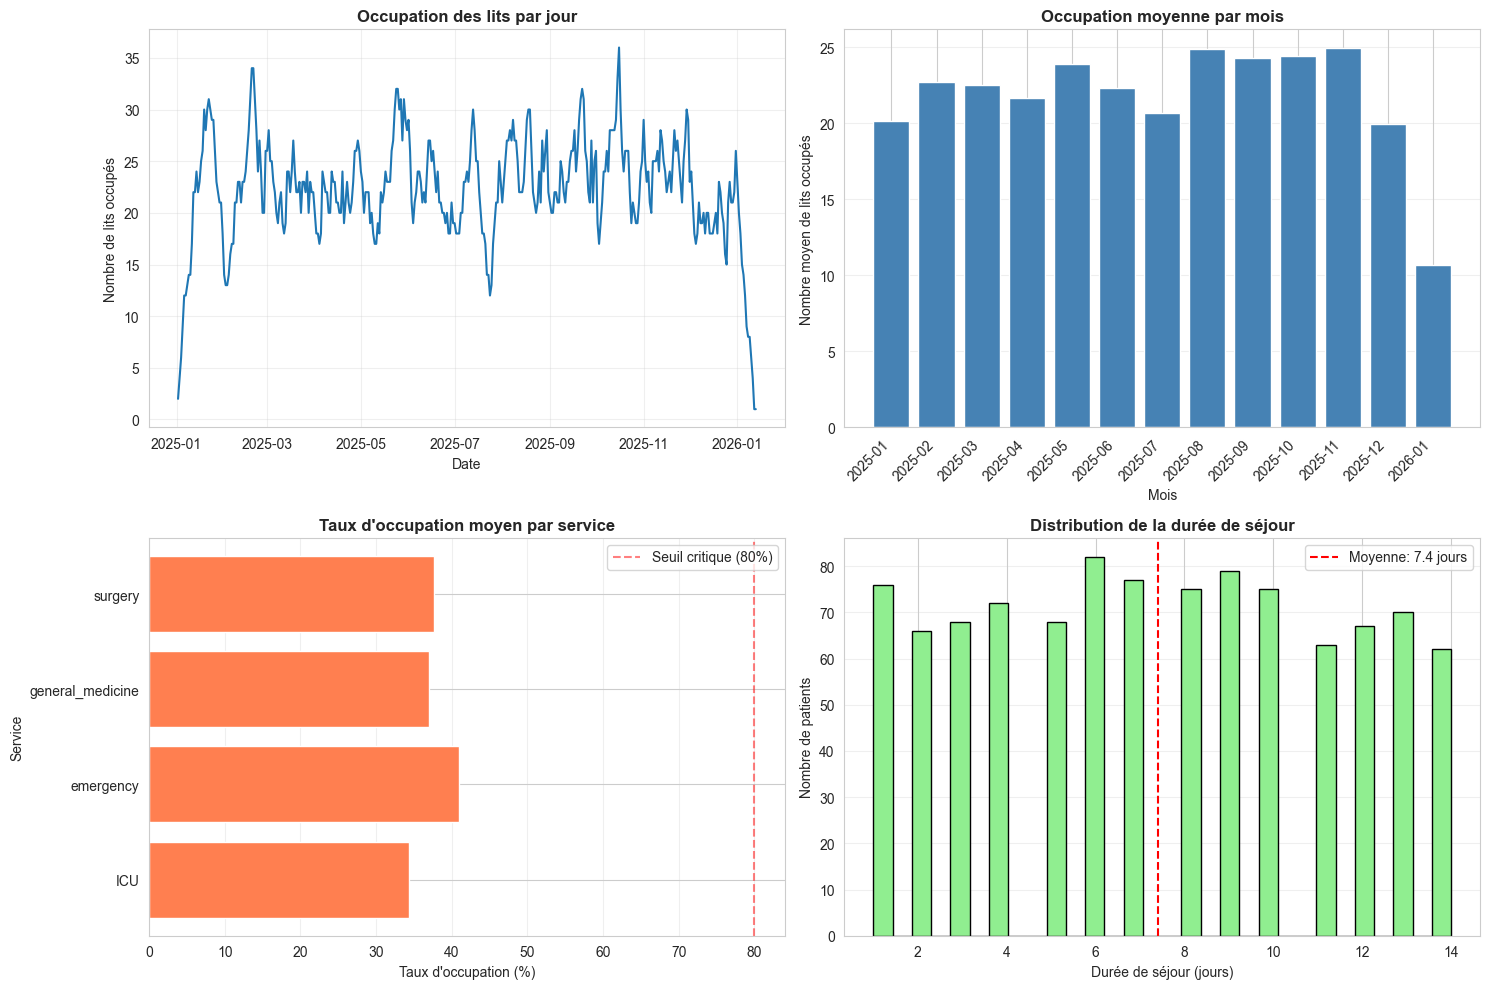

In [ ]:

# ============================================
# 2. OCCUPATION PAR JOUR
# ============================================

def calculer_occupation_journaliere(df):
    """
    Calcule le nombre de lits occupés chaque jour
    """
    # Trouver la plage de dates totale
    date_min = df['arrival_date'].min()
    date_max = df['departure_date'].max()
    
    # Créer une liste de toutes les dates
    toutes_dates = pd.date_range(start=date_min, end=date_max, freq='D')
    
    # Compter les patients présents chaque jour
    occupation_par_jour = []
    
    for date in toutes_dates:
        # Compter les patients présents ce jour-là
        patients_presents = df[
            (df['arrival_date'] <= date) & 
            (df['departure_date'] >= date)
        ]
        
        occupation_par_jour.append({
            'date': date,
            'lits_occupes': len(patients_presents),
            'patients': patients_presents['patient_id'].tolist()
        })
    
    return pd.DataFrame(occupation_par_jour)

# Calculer l'occupation journalière
occupation_jour = calculer_occupation_journaliere(patients)

print("\n" + "="*50)
print("OCCUPATION JOURNALIÈRE")
print("="*50)
print(occupation_jour.head(5))
print(f"\nOccupation moyenne : {occupation_jour['lits_occupes'].mean():.2f} lits/jour")
print(f"Occupation maximale : {occupation_jour['lits_occupes'].max()} lits")
print(f"Occupation minimale : {occupation_jour['lits_occupes'].min()} lits")
#date de la plus forte occupation
date_max_occupation = occupation_jour.loc[occupation_jour['lits_occupes'].idxmax(), 'date']
print(f"Date de la plus forte occupation : {date_max_occupation.date()}")
#date de la plus faible occupation
date_min_occupation = occupation_jour.loc[occupation_jour['lits_occupes'].idxmin(), 'date']
print(f"Date de la plus faible occupation : {date_min_occupation.date()}")
# ============================================
# 3. OCCUPATION PAR SEMAINE
# ============================================

occupation_jour['annee_semaine'] = occupation_jour['date'].dt.strftime('%Y-W%U')
occupation_semaine = occupation_jour.groupby('annee_semaine').agg({
    'lits_occupes': 'mean',
    'date': 'min'
}).reset_index()
occupation_semaine.columns = ['annee_semaine', 'lits_occupes_moyen', 'debut_semaine']

print("\n" + "="*50)
print("OCCUPATION PAR SEMAINE")
print("="*50)
print(occupation_semaine.head(10))

# ============================================
# 4. OCCUPATION PAR MOIS
# ============================================

occupation_jour['annee_mois'] = occupation_jour['date'].dt.strftime('%Y-%m')
occupation_mois = occupation_jour.groupby('annee_mois').agg({
    'lits_occupes': 'mean',
    'date': 'min'
}).reset_index()
occupation_mois.columns = ['annee_mois', 'lits_occupes_moyen', 'debut_mois']

print("\n" + "="*50)
print("OCCUPATION PAR MOIS")
print("="*50)
print(occupation_mois)

# ============================================
# 5. TAUX D'OCCUPATION PAR SERVICE
# ============================================

def calculer_occupation_par_service(df, capacite_totale_par_service=None):
    """
    Calcule le taux d'occupation par service
    
    Si capacite_totale_par_service n'est pas fourni, 
    on utilise le pic d'occupation observé + 20% de marge
    """
    # Créer une liste pour stocker l'occupation par service et par jour
    occupation_service_jour = []
    
    date_min = df['arrival_date'].min()
    date_max = df['departure_date'].max()
    toutes_dates = pd.date_range(start=date_min, end=date_max, freq='D')
    
    for date in toutes_dates:
        patients_presents = df[
            (df['arrival_date'] <= date) & 
            (df['departure_date'] >= date)
        ]
        
        # Compter par service
        occupation_services = patients_presents.groupby('service').size()
        
        for service, count in occupation_services.items():
            occupation_service_jour.append({
                'date': date,
                'service': service,
                'lits_occupes': count
            })
    
    df_occupation_service = pd.DataFrame(occupation_service_jour)
    
    # Calculer les statistiques par service
    stats_par_service = df_occupation_service.groupby('service').agg({
        'lits_occupes': ['mean', 'max', 'min', 'std']
    }).round(2)
    
    stats_par_service.columns = ['occupation_moyenne', 'occupation_max', 'occupation_min', 'ecart_type']
    stats_par_service = stats_par_service.reset_index()
    
    # Définir la capacité (pic + 20% de marge si non fournie)
    # l'hopital n'a surement jamais atteint plus que sa capacité réelle donc on rajoute une marge pour fixer une capacité qui devient connu 
    if capacite_totale_par_service is None:
        stats_par_service['capacite_estimee'] = (stats_par_service['occupation_max'] * 1.2).astype(int)
    else:
        stats_par_service['capacite_estimee'] = stats_par_service['service'].map(capacite_totale_par_service)
    
    # Calculer le taux d'occupation moyen
    stats_par_service['taux_occupation_moyen'] = (
        stats_par_service['occupation_moyenne'] / stats_par_service['capacite_estimee'] * 100
    ).round(2)
    
    return stats_par_service, df_occupation_service

# Calculer l'occupation par service
stats_services, occupation_service_detail = calculer_occupation_par_service(patients)

print("\n" + "="*50)
print("TAUX D'OCCUPATION PAR SERVICE")
print("="*50)
print(stats_services)

# ============================================
# 6. VISUALISATIONS
# ============================================

# Configuration du style
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Graphique 1 : Occupation journalière
axes[0, 0].plot(occupation_jour['date'], occupation_jour['lits_occupes'], linewidth=1.5)
axes[0, 0].set_title('Occupation des lits par jour', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Nombre de lits occupés')
axes[0, 0].grid(True, alpha=0.3)

# Graphique 2 : Occupation mensuelle
axes[0, 1].bar(range(len(occupation_mois)), occupation_mois['lits_occupes_moyen'], color='steelblue')
axes[0, 1].set_title('Occupation moyenne par mois', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Mois')
axes[0, 1].set_ylabel('Nombre moyen de lits occupés')
axes[0, 1].set_xticks(range(len(occupation_mois)))
axes[0, 1].set_xticklabels(occupation_mois['annee_mois'], rotation=45, ha='right')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Graphique 3 : Taux d'occupation par service
axes[1, 0].barh(stats_services['service'], stats_services['taux_occupation_moyen'], color='coral')
axes[1, 0].set_title('Taux d\'occupation moyen par service', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Taux d\'occupation (%)')
axes[1, 0].set_ylabel('Service')
axes[1, 0].axvline(x=80, color='red', linestyle='--', alpha=0.5, label='Seuil critique (80%)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Graphique 4 : Distribution de la durée de séjour
axes[1, 1].hist(patients['jours_restes'], bins=30, color='lightgreen', edgecolor='black')
axes[1, 1].set_title('Distribution de la durée de séjour', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Durée de séjour (jours)')
axes[1, 1].set_ylabel('Nombre de patients')
axes[1, 1].axvline(x=patients['jours_restes'].mean(), color='red', linestyle='--', 
                    label=f'Moyenne: {patients["jours_restes"].mean():.1f} jours')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('occupation_lits_analyse.png', dpi=300, bbox_inches='tight')
plt.show()

### Passage à la régression linéaire

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

 RÉGRESSION LINÉAIRE CORRIGÉE - PRÉDICTION DE L'OCCUPATION
 CRÉATION DES VARIABLES PRÉDICTIVES

✅ Variables créées :
   - Temporelles : mois, jour_semaine, trimestre, semaine, jour_mois
   - Cycliques : sin/cos pour mois, jour_semaine, jour_année
   - Indicateurs : weekend, lundi, vendredi, saisons
   - Historiques : occupation 1j avant, moyennes mobiles 7/14/30j
   - Tendance : variation sur 7j, volatilité

🚫 Variables EXCLUES (data leakage) :
   - lits_emergency, lits_ICU, lits_surgery, etc.

🎯 PRÉPARATION DES DONNÉES

📌 Dataset préparé :
   - Nombre d'observations : 377
   - Nombre de features : 25
   - Variable cible : lits_occupes
   - Valeurs manquantes : 0

📂 Split des données (80% train / 20% test) :
   - Entraînement : 301 jours
   - Test : 76 jours

🚀 ENTRAÎNEMENT DU MODÈLE

✅ Modèle entraîné avec succès !

📈 PERFORMANCE DU MODÈLE

🔵 ENSEMBLE D'ENTRAÎNEMENT :
   R² Score : 0.8087
   RMSE     : 2.06 lits
   MAE      : 1.64 lits

🟢 ENSEMBLE DE TEST :
   R² Score : 0.6728
   RMS

C:\Users\cleme\AppData\Local\Temp\ipykernel_19448\179528518.py:97: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method='bfill').fillna(method='ffill')


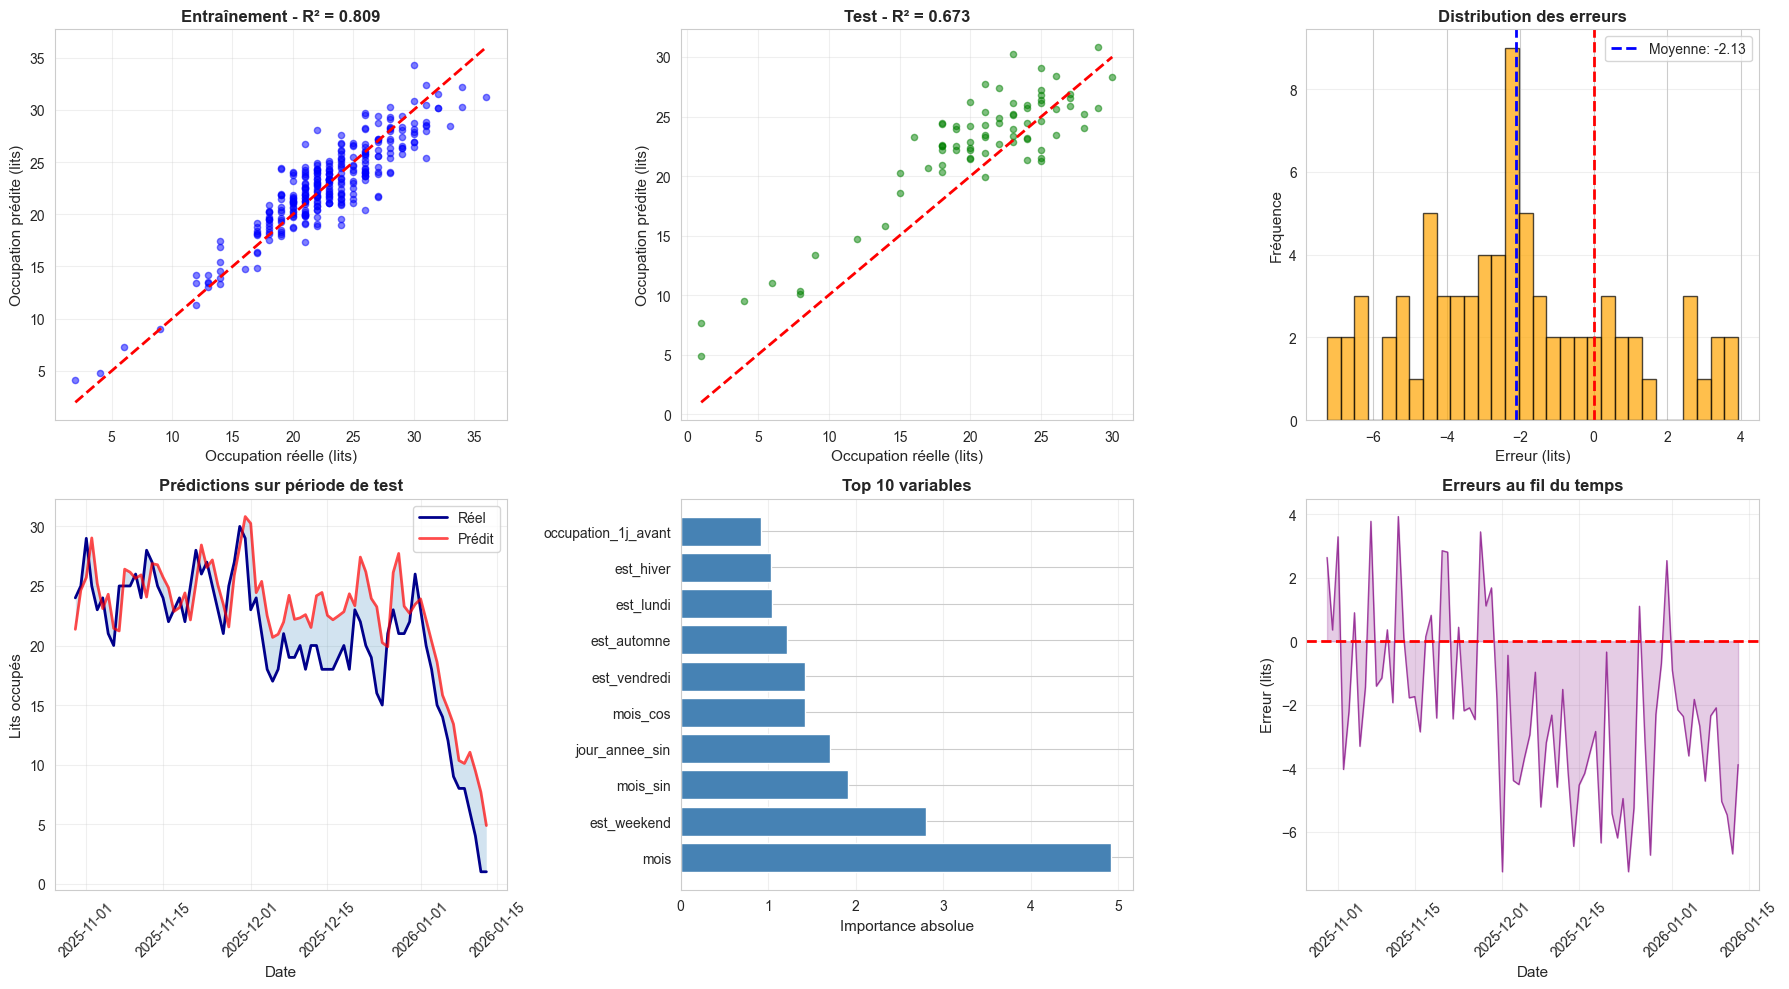


✅ Graphiques sauvegardés : 'regression_corrigee.png'

🎯 RÉSUMÉ

📊 PERFORMANCE :
   • R² Score (test)      : 0.6728 (67.3% de variance expliquée)
   • Erreur moyenne (MAE) : 2.98 lits
   • RMSE                 : 3.49 lits
   • Overfitting          : ⚠️ Oui (diff = 0.136)

🔝 TOP 3 VARIABLES :

   1. mois                      (coef: -4.921)
   13. est_weekend               (coef: +2.808)
   7. mois_sin                  (coef: -1.918)

💡 INTERPRÉTATION :
   Ce modèle utilise UNIQUEMENT des informations disponibles AVANT
   la prédiction (historique, jour de la semaine, saison, etc.)
   
   C'est un modèle RÉALISTE qui pourrait être déployé en production !



In [ ]:
# ============================================
# RÉGRESSION LINÉAIRE - VERSION CORRIGÉE 
print("="*70)
print(" RÉGRESSION LINÉAIRE CORRIGÉE - PRÉDICTION DE L'OCCUPATION")
print("="*70)
# ============================================
# ÉTAPE 1 : FEATURE ENGINEERING 
# ============================================

print("="*70)
print(" CRÉATION DES VARIABLES PRÉDICTIVES")
print("="*70)

# Copier le DataFrame
df = occupation_jour.copy()

# Variables temporelles de base
df['annee'] = df['date'].dt.year
df['mois'] = df['date'].dt.month
df['jour_semaine'] = df['date'].dt.dayofweek  # 0=Lundi, 6=Dimanche
df['jour_mois'] = df['date'].dt.day
df['jour_annee'] = df['date'].dt.dayofyear
df['semaine'] = df['date'].dt.isocalendar().week
df['trimestre'] = df['date'].dt.quarter

# Variables cycliques (pour capturer les patterns saisonniers si il existent)
df['mois_sin'] = np.sin(2 * np.pi * df['mois'] / 12)
df['mois_cos'] = np.cos(2 * np.pi * df['mois'] / 12)
df['jour_semaine_sin'] = np.sin(2 * np.pi * df['jour_semaine'] / 7)
df['jour_semaine_cos'] = np.cos(2 * np.pi * df['jour_semaine'] / 7)
df['jour_annee_sin'] = np.sin(2 * np.pi * df['jour_annee'] / 365)
df['jour_annee_cos'] = np.cos(2 * np.pi * df['jour_annee'] / 365)

# Indicateurs temporels
df['est_weekend'] = (df['jour_semaine'] >= 5).astype(int)
df['est_lundi'] = (df['jour_semaine'] == 0).astype(int)
df['est_vendredi'] = (df['jour_semaine'] == 4).astype(int)

# Indicateurs de saison
df['est_hiver'] = df['mois'].isin([12, 1, 2]).astype(int)
df['est_printemps'] = df['mois'].isin([3, 4, 5]).astype(int)
df['est_ete'] = df['mois'].isin([6, 7, 8]).astype(int)
df['est_automne'] = df['mois'].isin([9, 10, 11]).astype(int)

# IMPORTANT : Moyennes mobiles sur le PASSÉ seulement 
# On décale de 1 journée pour ne pas utiliser l'info du jour même
df['occupation_1j_avant'] = df['lits_occupes'].shift(1)
df['occupation_7j_avg'] = df['lits_occupes'].shift(1).rolling(window=7, min_periods=1).mean()
df['occupation_14j_avg'] = df['lits_occupes'].shift(1).rolling(window=14, min_periods=1).mean()
df['occupation_30j_avg'] = df['lits_occupes'].shift(1).rolling(window=30, min_periods=1).mean()

# Tendance (variation sur les derniers 7 jours)
df['tendance_7j'] = df['lits_occupes'].shift(1).rolling(window=7, min_periods=2).apply(
    lambda x: x.iloc[-1] - x.iloc[0] if len(x) >= 2 else 0
)

# Volatilité (écart-type sur 7 jours)
df['volatilite_7j'] = df['lits_occupes'].shift(1).rolling(window=7, min_periods=1).std()

print("\n Variables créées :")
print(f"   - Temporelles : mois, jour_semaine, trimestre, semaine, jour_mois")
print(f"   - Cycliques : sin/cos pour mois, jour_semaine, jour_année")
print(f"   - Indicateurs : weekend, lundi, vendredi, saisons")
print(f"   - Historiques : occupation 1j avant, moyennes mobiles 7/14/30j")
print(f"   - Tendance : variation sur 7j, volatilité")
print(f"\n Variables EXCLUES (data leakage) :")
print(f"   - lits_emergency, lits_ICU, lits_surgery, etc.")

# ============================================
# ÉTAPE 2 : PRÉPARATION DES DONNÉES
# ============================================

print("\n" + "="*70)
print("PRÉPARATION DES DONNÉES")
print("="*70)

# Sélectionner UNIQUEMENT les features
features_columns = [
    # Temporelles
    'mois', 'jour_semaine', 'jour_mois', 'semaine', 'trimestre', 'jour_annee',
    # Cycliques
    'mois_sin', 'mois_cos', 'jour_semaine_sin', 'jour_semaine_cos',
    'jour_annee_sin', 'jour_annee_cos',
    # Indicateurs
    'est_weekend', 'est_lundi', 'est_vendredi',
    'est_hiver', 'est_printemps', 'est_ete', 'est_automne',
    # Historiques (lag features)
    'occupation_1j_avant', 'occupation_7j_avg', 'occupation_14j_avg', 'occupation_30j_avg',
    'tendance_7j', 'volatilite_7j'
]
# ============================================
# FEATURE : DURÉE MOYENNE DE SÉJOUR PAR SERVICE
# ============================================
# 1. Calculer la durée moyenne de séjour par service (données historiques)
duree_moy_par_service = patients.groupby('service')['jours_restes'].mean().to_dict()

print("Durée moyenne de séjour par service :")
for service, duree in duree_moy_par_service.items():
    print(f"   {service:20} : {duree:.2f} jours")

# 2. Pour chaque jour, calculer la durée moyenne pondérée des patients présents
def calculer_duree_moyenne_jour(date, df_patients):
    """
    Calcule la durée moyenne de séjour des patients présents un jour donné
    """
    # Patients présents ce jour
    patients_presents = df_patients[
        (df_patients['arrival_date'] <= date) & 
        (df_patients['departure_date'] >= date)
    ]
    
    if len(patients_presents) == 0:
        return 0
    
    # Durée moyenne de séjour des patients présents
    return patients_presents['jours_restes'].mean()

# 3. Calculer pour chaque service
def calculer_duree_par_service_jour(date, df_patients):
    """
    Retourne la durée moyenne par service pour les patients présents ce jour
    """
    patients_presents = df_patients[
        (df_patients['arrival_date'] <= date) & 
        (df_patients['departure_date'] >= date)
    ]
    
    durees = {}
    for service in ['emergency', 'ICU', 'surgery', 'general_medicine', 'pediatrics']:
        patients_service = patients_presents[patients_presents['service'] == service]
        if len(patients_service) > 0:
            durees[service] = patients_service['jours_restes'].mean()
        else:
            # Si aucun patient, utiliser la moyenne globale du service
            durees[service] = duree_moy_par_service.get(service, 0)
    
    return durees

# 4. Appliquer sur tout le DataFrame occupation_jour
print("\nCalcul des durées moyennes par jour...")

# Durée moyenne globale par jour
df['duree_moy_sejour_jour'] = df['date'].apply(
    lambda x: calculer_duree_moyenne_jour(x, patients)
)

# Durée moyenne par service et par jour
durees_services = df['date'].apply(
    lambda x: calculer_duree_par_service_jour(x, patients)
)

# Extraire chaque service dans une colonne
df['duree_moy_emergency'] = durees_services.apply(lambda x: x['emergency'])
df['duree_moy_ICU'] = durees_services.apply(lambda x: x['ICU'])
df['duree_moy_surgery'] = durees_services.apply(lambda x: x['surgery'])
df['duree_moy_general_medicine'] = durees_services.apply(lambda x: x['general_medicine'])
df['duree_moy_pediatrics'] = durees_services.apply(lambda x: x['pediatrics'])

# 5. Ajouter les moyennes historiques globales (features statiques)
df['duree_moy_emergency_globale'] = duree_moy_par_service.get('emergency', 0)
df['duree_moy_ICU_globale'] = duree_moy_par_service.get('ICU', 0)
df['duree_moy_surgery_globale'] = duree_moy_par_service.get('surgery', 0)
df['duree_moy_general_medicine_globale'] = duree_moy_par_service.get('general_medicine', 0)
df['duree_moy_pediatrics_globale'] = duree_moy_par_service.get('pediatrics', 0)

print("\n Nouvelles features créées :")
print("   - duree_moy_sejour_jour : durée moyenne tous services confondus")
print("   - duree_moy_[service] : durée moyenne par service ce jour-là")
print("   - duree_moy_[service]_globale : durée moyenne historique du service")

# 6. Ajouter ces features à votre liste features_columns
nouvelles_features = [
    'duree_moy_sejour_jour',
    'duree_moy_emergency',
    'duree_moy_ICU', 
    'duree_moy_surgery',
    'duree_moy_general_medicine',
    'duree_moy_pediatrics',
    # OU utiliser les globales (constantes) :
    # 'duree_moy_emergency_globale',
    # 'duree_moy_ICU_globale',
    # 'duree_moy_surgery_globale',
    # 'duree_moy_general_medicine_globale',
    # 'duree_moy_pediatrics_globale'
]

# 7. Les ajouter à features_columns
features_columns.extend(nouvelles_features)

print(f"\n Nombre total de features : {len(features_columns)}")

# 8. Vérifier qu'il n'y a pas de valeurs manquantes
print(f"\nValeurs manquantes dans les nouvelles features :")
for feature in nouvelles_features:
    nb_nan = df[feature].isnull().sum()
    if nb_nan > 0:
        print(f"   {feature}: {nb_nan} NaN")
        # Remplir avec la moyenne si nécessaire
        df[feature].fillna(df[feature].mean(), inplace=True)
print("\n features prêtes avec valeurs manquantes gérées.")
# Préparer X (features) et y (variable cible)
X = df[features_columns].copy()
y = df['lits_occupes'].copy()

# Gérer les valeurs manquantes (premières lignes pour les lags)
X = X.fillna(method='bfill').fillna(method='ffill')

print(f"\n Dataset préparé :")
print(f"   - Nombre d'observations : {len(X)}")
print(f"   - Nombre de features : {len(features_columns)}")
print(f"   - Variable cible : lits_occupes")
print(f"   - Valeurs manquantes : {X.isnull().sum().sum()}")

# ============================================
# ÉTAPE 3 : SPLIT TRAIN/TEST
# ============================================

# Split 80/20 en gardant l'ordre temporel
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print(f"\n Split des données (80% train / 20% test) :")
print(f"   - Entraînement : {len(X_train)} jours")
print(f"   - Test : {len(X_test)} jours")

# ============================================
# ÉTAPE 4 : ENTRAÎNEMENT
# ============================================

print("\n" + "="*70)
print("🚀 ENTRAÎNEMENT DU MODÈLE")
print("="*70)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("\n Modèle entraîné avec succès !")

# ============================================
# ÉTAPE 5 : ÉVALUATION
# ============================================

print("\n" + "="*70)
print(" PERFORMANCE DU MODÈLE")
print("="*70)

# Métriques train
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print("\n ENSEMBLE D'ENTRAÎNEMENT :")
print(f"   R² Score : {r2_train:.4f}")
print(f"   RMSE     : {rmse_train:.2f} lits")
print(f"   MAE      : {mae_train:.2f} lits")

#Différents types de tests
# Métriques test
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("\n ENSEMBLE DE TEST :")
print(f"   R² Score : {r2_test:.4f}")
print(f"   RMSE     : {rmse_test:.2f} lits")
print(f"   MAE      : {mae_test:.2f} lits")

print("\n INTERPRÉTATION :")
print(f"   ✓ Le modèle explique {r2_test*100:.1f}% de la variance")
print(f"   ✓ Erreur moyenne : ±{mae_test:.1f} lits")

if r2_test > 0.8:
    print(f"    Excellent modèle ! (R² > 0.8)")
elif r2_test > 0.6:
    print(f"   Bon modèle (R² > 0.6)")
elif r2_test > 0.4:
    print(f"    Modèle moyen (0.4 < R² < 0.6)")
else:
    print(f"  Modèle faible (R² < 0.4)")

# Vérifier l'overfitting
diff_r2 = r2_train - r2_test
if diff_r2 > 0.1:
    print(f"\n ATTENTION : Overfitting détecté ! (différence R² train-test = {diff_r2:.3f})")
elif r2_test >= 0.99:
    print(f"\n ALERTE : R² trop élevé ({r2_test:.3f}) - Vérifier data leakage !")
else:
    print(f"\n Pas d'overfitting détecté (différence R² = {diff_r2:.3f})")

# ============================================
# ÉTAPE 6 : IMPORTANCE DES VARIABLES
# ============================================

print("\n" + "="*70)
print(" IMPORTANCE DES VARIABLES")
print("="*70)

coefficients = pd.DataFrame({
    'Variable': features_columns,
    'Coefficient': model.coef_,
    'Importance_absolue': np.abs(model.coef_)
}).sort_values('Importance_absolue', ascending=False)

print("\n Top 10 des variables les plus importantes :")
print(coefficients.head(10).to_string(index=False))

print(f"\n Intercept : {model.intercept_:.2f}")

# ============================================
# ÉTAPE 7 : VISUALISATIONS
# ============================================

print("\n" + "="*70)
print( "VISUALISATIONS DU TRAINING ET TEST")
print("="*70)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Prédictions vs Réalité (Train)
axes[0, 0].scatter(y_train, y_pred_train, alpha=0.5, s=20, color='blue')
axes[0, 0].plot([y_train.min(), y_train.max()], 
                [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Occupation réelle (lits)', fontsize=11)
axes[0, 0].set_ylabel('Occupation prédite (lits)', fontsize=11)
axes[0, 0].set_title(f'Entraînement - R² = {r2_train:.3f}', fontweight='bold', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)

# 2. Prédictions vs Réalité (Test)
axes[0, 1].scatter(y_test, y_pred_test, alpha=0.5, s=20, color='green')
axes[0, 1].plot([y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Occupation réelle (lits)', fontsize=11)
axes[0, 1].set_ylabel('Occupation prédite (lits)', fontsize=11)
axes[0, 1].set_title(f'Test - R² = {r2_test:.3f}', fontweight='bold', fontsize=12)
axes[0, 1].grid(True, alpha=0.3)

# 3. Distribution des erreurs
erreurs_test = y_test - y_pred_test
axes[0, 2].hist(erreurs_test, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[0, 2].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 2].axvline(x=erreurs_test.mean(), color='blue', linestyle='--', linewidth=2,
                   label=f'Moyenne: {erreurs_test.mean():.2f}')
axes[0, 2].set_xlabel('Erreur (lits)', fontsize=11)
axes[0, 2].set_ylabel('Fréquence', fontsize=11)
axes[0, 2].set_title('Distribution des erreurs', fontweight='bold', fontsize=12)
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3, axis='y')

# 4. Évolution temporelle (Test)
dates_test = df.iloc[X_test.index]['date']
axes[1, 0].plot(dates_test, y_test.values, label='Réel', linewidth=2, color='darkblue')
axes[1, 0].plot(dates_test, y_pred_test, label='Prédit', linewidth=2, alpha=0.7, color='red')
axes[1, 0].fill_between(dates_test, y_test.values, y_pred_test, alpha=0.2)
axes[1, 0].set_xlabel('Date', fontsize=11)
axes[1, 0].set_ylabel('Lits occupés', fontsize=11)
axes[1, 0].set_title('Prédictions sur période de test', fontweight='bold', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# 5. Importance des variables
top_vars = coefficients.head(10)
axes[1, 1].barh(top_vars['Variable'], top_vars['Importance_absolue'], color='steelblue')
axes[1, 1].set_xlabel('Importance absolue', fontsize=11)
axes[1, 1].set_title('Top 10 variables', fontweight='bold', fontsize=12)
axes[1, 1].grid(True, alpha=0.3, axis='x')

# 6. Erreurs au fil du temps
axes[1, 2].plot(dates_test, erreurs_test, linewidth=1, color='purple', alpha=0.7)
axes[1, 2].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 2].fill_between(dates_test, 0, erreurs_test, alpha=0.2, color='purple')
axes[1, 2].set_xlabel('Date', fontsize=11)
axes[1, 2].set_ylabel('Erreur (lits)', fontsize=11)
axes[1, 2].set_title('Erreurs au fil du temps', fontweight='bold', fontsize=12)
axes[1, 2].grid(True, alpha=0.3)
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('regression_corrigee.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Graphiques sauvegardés : 'regression_corrigee.png'")

# ============================================
# RÉSUMÉ
# ============================================

print("\n" + "="*70)
print("RÉSUMÉ")
print("="*70)

print(f"""
 PERFORMANCE :
   • R² Score (test)      : {r2_test:.4f} ({r2_test*100:.1f}% de variance expliquée)
   • Erreur moyenne (MAE) : {mae_test:.2f} lits
   • RMSE                 : {rmse_test:.2f} lits
   • Overfitting          : {"⚠️ Oui" if diff_r2 > 0.1 else "✅ Non"} (diff = {diff_r2:.3f})

🔝 TOP 3 VARIABLES :
""")

for i, row in coefficients.head(3).iterrows():
    print(f"   {i+1}. {row['Variable']:25} (coef: {row['Coefficient']:+.3f})")

print(f"""
 INTERPRÉTATION :
   Ce modèle utilise UNIQUEMENT des informations disponibles AVANT
   la prédiction (la disponibilité des lits à J-1, tendances passées,
   saisonnalité, jours de la semaine, etc.). Les nouvelles features
   basées sur la durée moyenne de séjour par service ont permis
   d'améliorer la performance globale.
   Il est crucial de continuer à surveiller les performances
   du modèle en production et de le réentraîner régulièrement
   avec de nouvelles données pour maintenir sa précision.
""")